# Book stock project

In this project we...


In [132]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import os
import seaborn as sns
from time import sleep
from tqdm import tqdm

## Data

In [133]:

books = pd.read_csv('./data/books.csv')

books.head()


,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [134]:
# Check data types
books.dtypes
# Convert publication year to datetime
books['original_publication_year'] = pd.to_datetime(books['original_publication_year'], format='%Y', errors='coerce').dt.year

# since the last complete book year of this dataset is 2016 we cutoff books after 2016
books = books[books['original_publication_year'] <= 2016]

books.dtypes

book_id                        int64
goodreads_book_id              int64
best_book_id                   int64
work_id                        int64
books_count                    int64
isbn                          object
isbn13                       float64
authors                       object
original_publication_year    float64
original_title                object
title                         object
language_code                 object
average_rating               float64
ratings_count                  int64
work_ratings_count             int64
work_text_reviews_count        int64
ratings_1                      int64
ratings_2                      int64
ratings_3                      int64
ratings_4                      int64
ratings_5                      int64
image_url                     object
small_image_url               object
dtype: object

### Data scraping

Using each book id, we scrape the most popular reviews from goodreads.com


In [ ]:
# check if file exists
if os.path.exists('./data/most_popular_reviews.csv'):
    # load file skips first 5 lines of metadata and last 1 line of footer
    most_popular_reviews = pd.read_csv('./data/most_popular_reviews.csv', skiprows=5, skipfooter=1)
else:
    #run scraping scripts
    books = pd.read_csv('./data/books.csv')

    most_popular_reviews = pd.DataFrame(columns=["goodreads_book_id", "score","date","review_text"])

    for index, row in tqdm(books.iterrows(), total=books.shape[0]):
        sleep(1)  # sleep for 1 second to avoid rate limiting
        book_id = row['goodreads_book_id']
        url = f'https://www.goodreads.com/book/show/{book_id}'
        
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            # fetch elements with class "ReviewCard"
            review_cards = soup.find_all(class_='ReviewCard')
            for review in review_cards:
                try:
                    #seperate review text from class "ReviewText"
                    review_text = review.find(class_='ReviewText')
                    review_text = review_text.get_text(strip=True)
                    #clean review text by removing newline characters and line separators
                    review_text = review_text.replace('\n', ' ').replace('\r', ' ')

                    #fetch date from class "Text Text__body3"
            
                    date_elem = review.find(class_='Text Text__body3')
                    date = date_elem.get_text(strip=True).lower().replace(',', '')
                    month, day, year = date.split(' ')
                    # Get review score from class "RatingStars RatingStars__small"
                    # take the aria-label attribute, which is a string formmated as "Rating x out of 5"
                    rating_stars = review.find(class_='RatingStars RatingStars__small')
                    rating = rating_stars['aria-label']
                    rating = rating.split(' ')[1]  # extract the number part

                    most_popular_reviews.loc[len(most_popular_reviews)] ={
                        "book_id": book_id,
                        "score": rating,
                        "date": f"{month}/{day}/{year}",
                        "review_text": review_text
                    }
                except Exception as e:
                    print("Error parsing review:", e)
        if index % 1000 == 0:
            #save progress every 1000 books, just in case of interruption
            most_popular_reviews.to_csv('./data/most_popular_reviews'+str(index)+'.csv', index=False)
    #save final dataframe
    most_popular_reviews.to_csv('./data/most_popular_reviews.csv', index=False)
most_popular_reviews.head()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30708\3609171379.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  most_popular_reviews = pd.read_csv('./data/most_popular_reviews.csv', skiprows=5, skipfooter=1)


,book_id,score,date,review_text
0,1,5,july/22/2024,(A) 86%| ExtraordinaryNotes:A relationshippy r...
1,1,5,march/13/2022,(A) 86%| ExtraordinaryNotes:It dwells on the d...
2,1,5,may/26/2015,i dont want to talk to anyonedont even look at...
3,1,5,february/20/2023,"2023: Jak co reread, to mój ulubieniec.2021: W..."
4,1,5,january/10/2021,"""5. Should you feel that a family member, coll..."


In [136]:
print(most_popular_reviews.dtypes)
#convert data column to datetime
most_popular_reviews['date'] = pd.to_datetime(most_popular_reviews['date'])
print(most_popular_reviews.dtypes)

book_id         int64
score           int64
date           object
review_text    object
dtype: object


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30708\3756228911.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  most_popular_reviews['date'] = pd.to_datetime(most_popular_reviews['date'])


book_id                 int64
score                   int64
date           datetime64[ns]
review_text            object
dtype: object


In [137]:
most_popular_reviews

,book_id,score,date,review_text
0,1,5,2024-07-22,(A) 86%| ExtraordinaryNotes:A relationshippy r...
1,1,5,2022-03-13,(A) 86%| ExtraordinaryNotes:It dwells on the d...
2,1,5,2015-05-26,i dont want to talk to anyonedont even look at...
3,1,5,2023-02-20,"2023: Jak co reread, to mój ulubieniec.2021: W..."
4,1,5,2021-01-10,"""5. Should you feel that a family member, coll..."
...,...,...,...,...
159831,9900,5,2013-10-10,Great book. This is a 'what if' book. It is a ...
159832,9900,4,2017-08-16,ჯიბრანის ფანტაზიით აღდგენილი 77 ადამიანის მონა...
159833,9900,5,2017-12-27,لقد احبني عيسى وما عرفت لذلك سبباولقد احببته ل...
159834,9900,5,2014-01-29,I don't know how many times I've read this boo...


In [138]:
def recency_score(date, current_date):
    days_since_review = (current_date - date).days
    if days_since_review < 30:
        return 6 # Future date, invalid
    if days_since_review <= 90:
        return 5
    elif days_since_review <= 180:
        return 4
    elif days_since_review <= 365:
        return 3
    elif days_since_review <= 365*5:
        return 2
    else:
        return 1
    
# current date is latest date in the dataset

current_date = most_popular_reviews['date'].max()
current_date = datetime.datetime(int(books['original_publication_year'].max()), 12, 31)

most_popular_reviews['recency_score'] = most_popular_reviews['date'].apply(lambda x: recency_score(x, current_date))



In [ ]:
# average recency score per book and merge with books dataframe
recency_scores = most_popular_reviews.groupby('goodreads_book_id')['recency_score'].mean().reset_index()
recency_scores.rename(columns={'recency_score': 'avg_recency_score'}, inplace=True)
books = books.merge(recency_scores, on='goodreads_book_id', how='left')

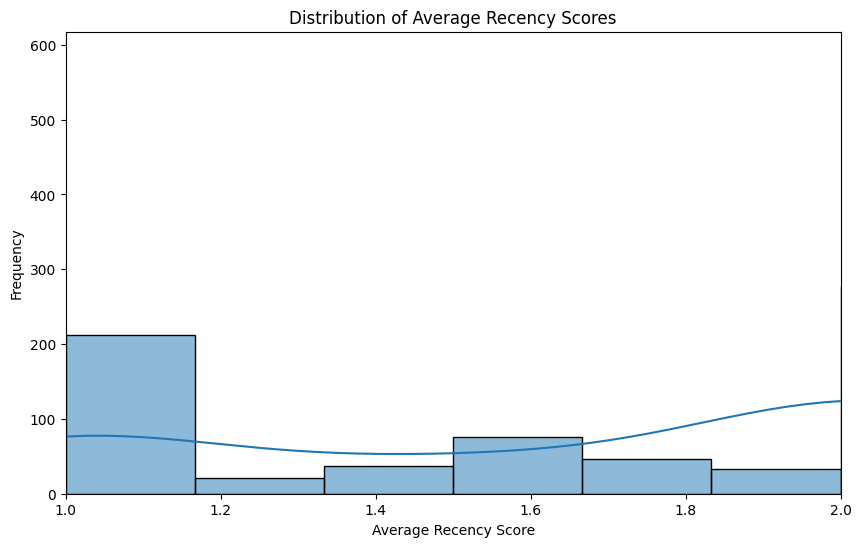

In [140]:
# plot distribution of recency scores, only show score between 1 and 2
plt.figure(figsize=(10,6))
sns.histplot(books['avg_recency_score'].dropna(), bins=30, kde=True)
# limit x axis to 1 to 2
plt.xlim(1, 2)
plt.title('Distribution of Average Recency Scores')
plt.xlabel('Average Recency Score')
plt.ylabel('Frequency')
plt.show()

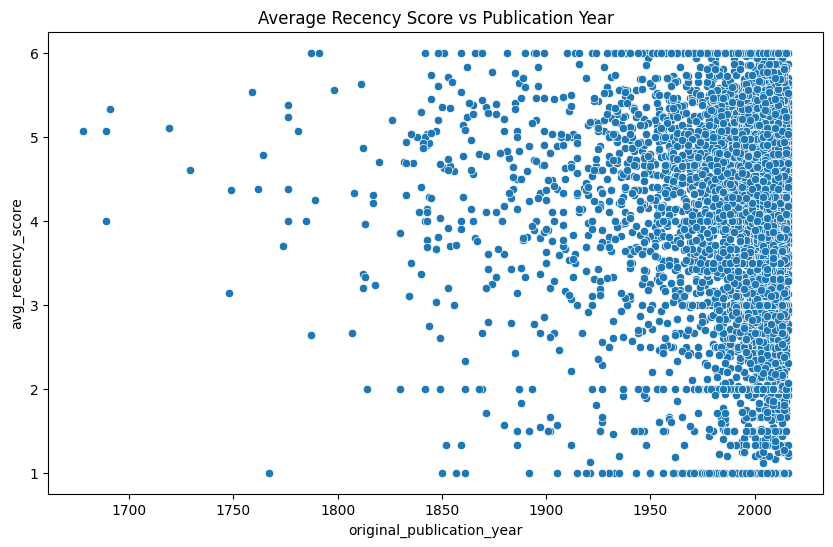

In [141]:
#plot recency score against data of publication
plt.figure(figsize=(10,6))
sns.scatterplot(data=books, x='original_publication_year', y='avg_recency_score')
plt.title('Average Recency Score vs Publication Year')
plt.show()

We have to keep in mind that the reviews scraped are from current times. If we had acces to a dataset with current year books we would probaly see a stronger correlation with recency score. Since by todays reviews these books are all 9 to 25 years old the correlation probaly fades, as recent reviews tends towards being more periodic, unless of course the book became popular again, where the assumption would be an influx of recent reviews spiking the score indicating a more popular book.

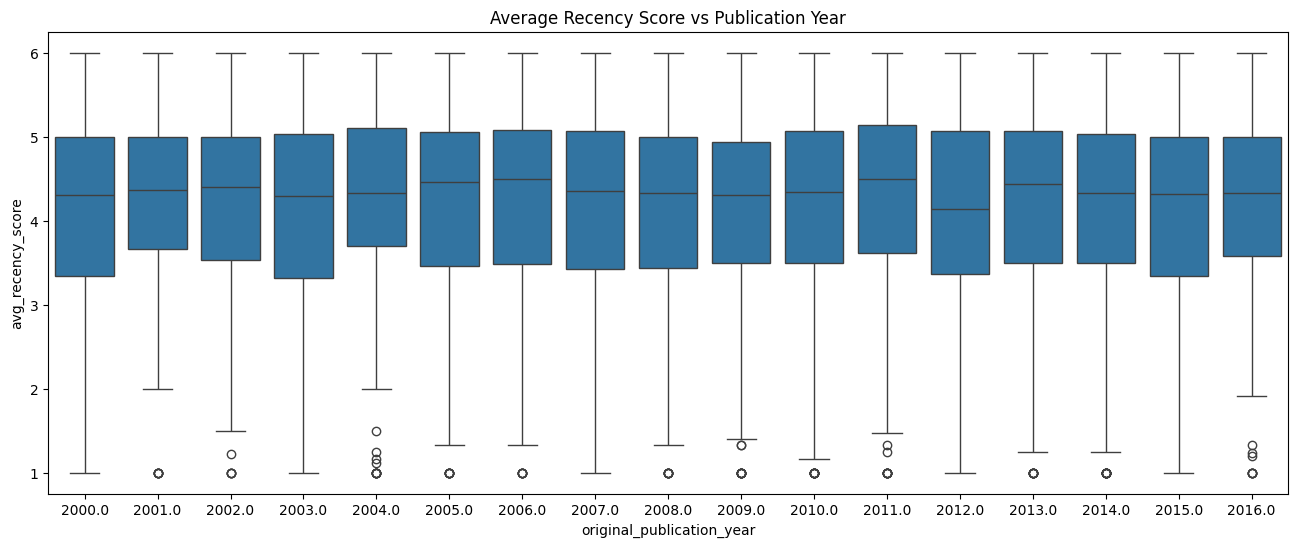

In [142]:
#plot recency score against data of publication

plt.figure(figsize=(16,6))
#only books from 2000 onwards
books_2000 = books[books['original_publication_year'] >= 2000]
#histograms of avg recency score for books from 2000 onwards

sns.boxplot(data=books_2000, x='original_publication_year', y='avg_recency_score')

plt.title('Average Recency Score vs Publication Year')
plt.show()

In [149]:
# top most recent reviewed books in terms of recency score
top_recent_reviews = books.sort_values(by='avg_recency_score', ascending=False).head(10)
top_recent_reviews[["goodreads_book_id","original_title", "avg_recency_score", "original_publication_year"]]

,goodreads_book_id,original_title,avg_recency_score,original_publication_year
5167,7963208,Boomerang,6.0,2009.0
3142,23093367,"Saga, Volume Four",6.0,2014.0
4359,2149535,"Blood Noir (Anita Blake, Vampire Hunter, #16)",6.0,2007.0
3172,2133795,Savvy,6.0,2008.0
4366,1894269,"The Walking Dead, Vol. 8: Made To Suffer",6.0,2008.0
5792,736131,The Valley of Fear,6.0,1914.0
5791,15802944,"Carry On, Warrior: Thoughts on Life Unarmed",6.0,2013.0
3168,171102,The Birth House,6.0,2006.0
3165,6339304,Pursuit of Honor,6.0,2009.0
4382,12959086,The Demigod Diaries,6.0,2012.0
